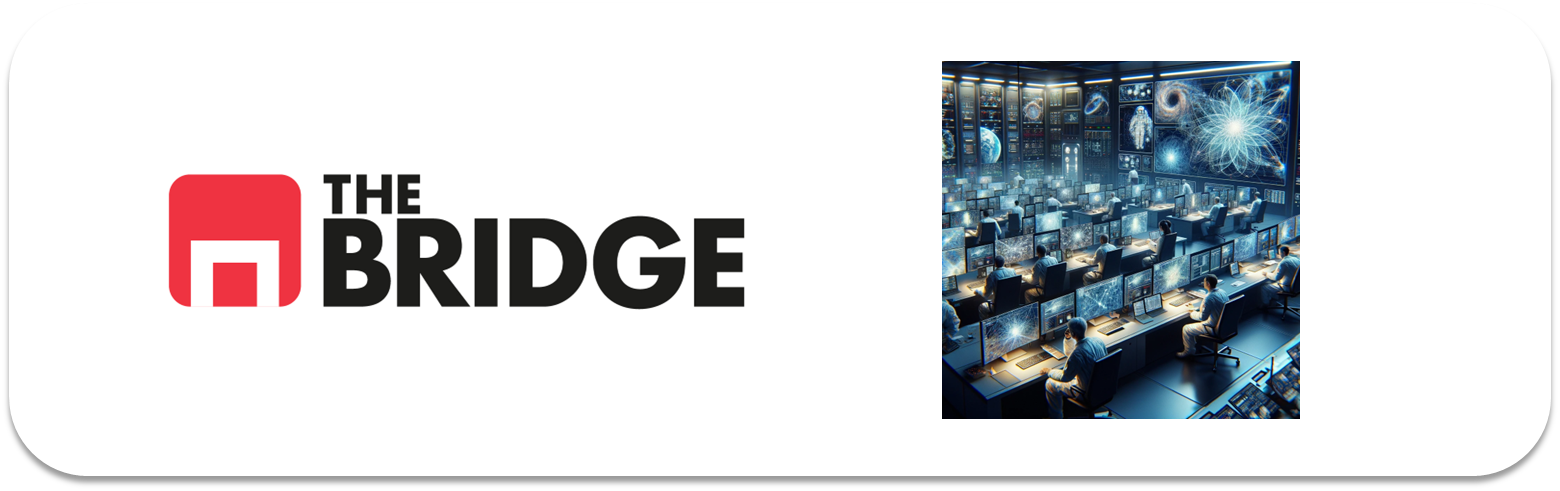

## PRACTICA OBLIGATORIA: **Transfer Learning y Fine Tuning**

* La práctica obligatoria de esta unidad consiste en un repetir el ejercicio de construcción de un modelo de clasificación de paisajes pero usando un modelo preentrenado. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [34]:
 import cv2
from tensorflow import keras  # Corrección de importación
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns

from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

### Objetivo del ejercicio

Comparar una red convolucional hecha ad-hoc frente a los modelos preentrenados y ajustados con fine tuning y transfer learning. Para ello emplea el dataset de paisajes del conjunto de ejercicios de la unidad anterior.


### Se pide

1. Preparar los datos del modelo y las funciones de visualización, copia para ello todo lo que necesites de las soluciones del ejercicio de clasificación de paisajes de la unidad anterior.

2. Escoger entre uno de los modelos VGG-19, InceptionV3 y MobileNetV2 (todos en https://keras.io/api/applications/) (Se aconseja este último si no tenemos un ordenador muy potente). Si no te haces con estos puedes recurrir a la ResNetV50.

4. Hacer un transfer-learning con una cabeza de como mucho 2 capas densas ocultas y una de salida. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

5. Hacer un fine-tuning con la misma cabeza diseñada en el punto anterior. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

6. Comparar los resultados con los obtenidos con la red convolucional del ejercicio mencionado.

EXTRA:
- Repetir el transfer learning empleando aumentado de imágenes.



In [35]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("puneet6060/intel-image-classification")

print("Path to dataset files:", path)


Path to dataset files: C:\Users\iagog\.cache\kagglehub\datasets\puneet6060\intel-image-classification\versions\2


In [ ]:
import os

# Nueva ruta en Windows
TRAIN_PATH = "C:\\Users\\iagog\\.cache\\kagglehub\\datasets\\puneet6060\\intel-image-classification\\versions\\2\\seg_train\\seg_train"
TEST_PATH = "C:\\Users\\iagog\\.cache\\kagglehub\\datasets\\puneet6060\\intel-image-classification\\versions\\2\\seg_test\\seg_test"

# Verifica si la ruta existe
print("¿Existe TRAIN_PATH?", os.path.exists(TRAIN_PATH))
print("¿Existe TEST_PATH?", os.path.exists(TEST_PATH))


¿Existe TRAIN_PATH? True
¿Existe TEST_PATH? True


In [37]:
ROOT_PATH = "/root/.cache/kaggle/datasets/puneet6060/intel-image-classification/versions/2/"



Introducimos un parámetro de control de la resolución, según las dimensiones de entrada de nuestra red, pero que podamos tocar sin cambiar nada del resto de l código para poder probar otras resoluciones.

In [38]:
IMG_WIDTH = IMG_HEIGHT = 75

In [39]:
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.io import imread

def read_data(directorio, reshape_dim=(75, 75)):  # Ajustado reshape_dim para evitar referencias no declaradas
    X = []
    y = []
    for folder in os.listdir(directorio):
        print(folder)
        if os.path.isdir(os.path.join(directorio, folder)):
            for file in os.listdir(os.path.join(directorio, folder)):
                image_path = os.path.join(directorio, folder, file)
                image = imread(image_path)
                image = cv2.resize(image, reshape_dim)  # Redimensionamos las imágenes a las dimensiones dadas
                X.append(image)
                y.append(folder)
    return np.array(X), np.array(y)

def show_images_batch(paisajes, names=[], n_cols=5, size_scale=2):
    n_rows = ((len(paisajes) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1 * size_scale))
    for index, paisaje in enumerate(paisajes):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(paisaje, cmap="Greys")
        plt.axis("off")
        if names:
            plt.title(names[index])



In [40]:
import os
import cv2
from skimage.io import imread

def read_data(directorio, reshape_dim=(150, 150)):  
    X = []
    y = []
    
    for folder in os.listdir(directorio):
        folder_path = os.path.join(directorio, folder)
        
        if not os.path.isdir(folder_path):  
            continue  # Omitir si no es una carpeta

        for file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, file)

            # Verifica que sea un archivo de imagen antes de leerlo
            if not image_path.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".tiff")):
                continue

            image = imread(image_path)  
            image = cv2.resize(image, reshape_dim)  

            X.append(image)
            y.append(folder)  # Usa el nombre de la carpeta como la etiqueta

    return X, y


In [41]:
# Uso de rutas corregidas y variables adecuadas
# Asegúrate de definir `TRAIN_PATH` y `TEST_PATH` correctamente en tu entorno
X_train, y_train = read_data(TRAIN_PATH)
X_test, y_test = read_data(TEST_PATH)

In [43]:
import os
print("Contenido de TRAIN_PATH:", os.listdir(TRAIN_PATH))


Contenido de TRAIN_PATH: ['seg_train']


In [49]:
X_train, y_train = read_data(TRAIN_PATH)


✅ Cargando: C:\Users\iagog\.cache\kagglehub\datasets\puneet6060\intel-image-classification\versions\2\seg_train\seg_train\buildings\0.jpg
✅ Cargando: C:\Users\iagog\.cache\kagglehub\datasets\puneet6060\intel-image-classification\versions\2\seg_train\seg_train\buildings\10006.jpg
✅ Cargando: C:\Users\iagog\.cache\kagglehub\datasets\puneet6060\intel-image-classification\versions\2\seg_train\seg_train\buildings\1001.jpg
✅ Cargando: C:\Users\iagog\.cache\kagglehub\datasets\puneet6060\intel-image-classification\versions\2\seg_train\seg_train\buildings\10014.jpg
✅ Cargando: C:\Users\iagog\.cache\kagglehub\datasets\puneet6060\intel-image-classification\versions\2\seg_train\seg_train\buildings\10018.jpg
✅ Cargando: C:\Users\iagog\.cache\kagglehub\datasets\puneet6060\intel-image-classification\versions\2\seg_train\seg_train\buildings\10029.jpg
✅ Cargando: C:\Users\iagog\.cache\kagglehub\datasets\puneet6060\intel-image-classification\versions\2\seg_train\seg_train\buildings\10032.jpg
✅ Cargando:

In [51]:
import os

print("Contenido de TRAIN_PATH:", os.listdir(TRAIN_PATH))


Contenido de TRAIN_PATH: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [54]:
def show_images_batch(paisajes, names=None, n_cols=5, size_scale=0.3):
    n_images = len(paisajes)
    n_rows = (n_images // n_cols) + (1 if n_images % n_cols != 0 else 0)
    
    plt.figure(figsize=(n_cols * size_scale, n_rows * size_scale))
    
    for index, paisaje in enumerate(paisajes):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(paisaje)
        plt.axis('off')
        
        # Solo poner el nombre si está disponible
        if names is not None and len(names) > 0:
            plt.title(names[index])
    
    plt.show()



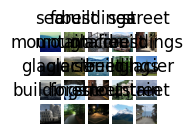

In [55]:
indices = np.random.randint(0, len(X_train), 20)
show_images_batch(X_train[indices], names = y_train[indices], n_cols = 5)

ESCALAMOS


In [61]:
import numpy as np

# Convertir X_train y X_test a arreglos de Numpy
X_train = np.array(X_train)
X_test = np.array(X_test)

# Normalizar las imágenes (dividir por 255)
X_train = X_train / 255.0
X_test = X_test / 255.0


Selección de modelo a tranferir y tunear (Inception V3)

In [62]:
from keras.applications import InceptionV3

Transfer Learning

In [64]:
IMG_WIDTH = IMG_HEIGHT = 75

# Cargamos el modelo pre-entrenado
base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

# Congelamos sus capas
for layer in base_model.layers:
    layer.trainable = False

# Capa de aplanado de la salida del modelo base
def prepare_model(base_model = base_model): # Lo creamos así para poder reinicializarlo en cada reentrenamiento en ejercicios posteriores
    x = keras.layers.Flatten()(base_model.output)

    # Tantas unidades como el flatten de la salida de Inception -> 5625 features
    x = keras.layers.Dense(2048, activation='relu')(x)
    x = keras.layers.Dropout(rate = 0.25)(x)

    # Capa final de salida con 6 neuronas (una por clase) y activación softmax
    x = keras.layers.Dense(6, activation='softmax')(x)

    model = keras.Model(base_model.input, x)

    model.compile(
        optimizer = 'adam',
        loss = 'sparse_categorical_crossentropy', # sparse -> y es un array de escalares pero hay varias categorías, y un array de vectores
        metrics = ['acc']
    )

    return model

# Observamos la arquitectura del modelo
model= prepare_model()
model.summary()


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 75, 75, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 37, 37,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 37, 37,    │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 37, 37,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 35, 35,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 35, 35,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 17, 17,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 17, 17,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 17, 17,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 17, 17,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 15, 15,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 15, 15,    │          0 │ batch_normalizat

 Total params: 26,011,430 (99.23 MB)

 Trainable params: 4,208,646 (16.05 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

Configuramos el resto de hiperparámetros, batch_size y nº de epocas y el EarlyStopping

In [65]:
instancias_train = len(X_train)
for i in range(1, 5):
    print(f"Batch_size: {32*i}, num_steps_per_epoch: {round(instancias_train/(32*i))}")


Batch_size: 32, num_steps_per_epoch: 439
Batch_size: 64, num_steps_per_epoch: 219
Batch_size: 96, num_steps_per_epoch: 146
Batch_size: 128, num_steps_per_epoch: 110


In [66]:
# Convertir etiquetas a numeros
targets = pd.Series(y_train)

In [68]:
mapa = {tipo:indice for indice, tipo in enumerate(targets.unique())}
mapa

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [71]:
y_train_num = np.array([mapa[y] for y in y_train])
y_test_num = np.array([mapa[y] for y in y_test])

In [74]:

from time import time
for batch_size in [32, 64, 96, 128]:
    t_zero = time()
    model = prepare_model()
    history = model.fit(X_train,
                        y_train_num,
                        batch_size=batch_size,
                        validation_split=0.2,
                        epochs=1)
    tiempo = round(time() - t_zero, 3)
    print(f"batch_size: {batch_size}, num_steps: {len(X_train)/batch_size}, tiempo 1 epoca: {tiempo}, tiempo 20 epocas: {tiempo * 20}")


ValueError: Input 0 of layer "functional_2" is incompatible with the layer: expected shape=(None, 75, 75, 3), found shape=(None, 150, 150, 3)

## (...)